In [1]:
import torch
print(torch.cuda.is_available())
print(torch.version.cuda)

# conda install -c omgarcia gcc-6 # install GCC version 6
# conda install libgcc

True
11.1


In [2]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

import os 

from detectron2 import model_zoo
from detectron2.config import get_cfg

In [3]:
from detectron2.data.datasets.coco import register_coco_instances, convert_to_coco_dict

from pathlib import Path

data_path = Path('data/SpermSegGS/')

if not Path('cocosplit.py').exists():
    !wget https://raw.githubusercontent.com/akarazniewicz/cocosplit/master/cocosplit.py
!python cocosplit.py --having-annotations -s 0.75 coco_train.json train.json val.json

register_coco_instances("sperm-train", {}, "train.json", "")
register_coco_instances("sperm-val", {}, "val.json", "")
register_coco_instances("sperm-test", {}, "coco_test.json", "")

Saved 33 entries in train.json and 12 in val.json


In [1]:
from detectron2.data import build_detection_train_loader
from detectron2.evaluation import COCOEvaluator
import detectron2.data.transforms as T

from utils.trainer import MyTrainer

class InvertColors(T.Augmentation):
    def get_transform(self, image):
        return T.ColorTransform(lambda x: 255-x)

def custom_mapper(dataset_dict):
    dataset_dict = copy.deepcopy(dataset_dict)  # it will be modified by code below
    image = utils.read_image(dataset_dict["file_name"], format="BGR")
    transform_list = [
        InvertColors(),
        T.RandomBrightness(0.8, 1.8),
        T.RandomContrast(0.6, 1.3),
        T.RandomSaturation(0.8, 1.4),
        T.RandomLighting(0.7),
    ]
    image, transforms = T.apply_transform_gens(transform_list, image)
    dataset_dict["image"] = torch.as_tensor(image.transpose(2, 0, 1).astype("float32"))

    annos = [
        utils.transform_instance_annotations(obj, transforms, image.shape[:2])
        for obj in dataset_dict.pop("annotations")
    ]
    instances = utils.annotations_to_instances(annos, image.shape[:2])
    dataset_dict["instances"] = utils.filter_empty_instances(instances)
    return dataset_dict


class Trainer(MyTrainer):
    @classmethod
    def build_train_loader(cls, cfg):
        return build_detection_train_loader(cfg, mapper=custom_mapper)
    
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
        return COCOEvaluator(dataset_name, ('segm',), False, output_folder)

In [10]:
from detectron2.engine import DefaultTrainer



cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("sperm-train",)
cfg.DATASETS.TEST = ("sperm-test",)
cfg.TEST.EVAL_PERIOD = 250
cfg.DATALOADER.NUM_WORKERS = 9
cfg.MODEL.WEIGHTS = 'https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl'
# cfg.MODEL.WEIGHTS = 'https://dl.fbaipublicfiles.com/detectron2/new_baselines/mask_rcnn_R_50_FPN_200ep_LSJ/42047638/model_final_89a8d3.pkl'
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00010  # pick a good LR
cfg.SOLVER.MAX_ITER = 2500    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset

# cfg.SOLVER.STEPS = []        # do not decay learning rate

# faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 32 
# # see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3  

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = MyTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[07/04 05:43:37 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

WARNING [07/04 05:43:37 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[07/04 05:43:37 d2.data.datasets.coco]: Loaded 33 images in COCO format from train.json
[07/04 05:43:37 d2.data.build]: Removed 0 images with no usable annotations. 33 images left.
[07/04 05:43:37 d2.data.build]: Using training sampler TrainingSampler
[07/04 05:43:37 d2.data.common]: Serializing 33 elements to byte tensors and concatenating them all ...
[07/04 05:43:37 d2.data.common]: Serialized dataset takes 0.13 MiB
WARNING [07/04 05:43:37 d2.solver.build]: SOLVER.STEPS contains values larger than SOLVER.MAX_ITER. These values will be ignored.
[07/04 05:43:37 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
WARNING [07/04 05:43:37 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #cate

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (12, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (12,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (3, 256, 1, 1) 

[07/04 05:43:37 d2.engine.train_loop]: Starting training from iteration 0
[07/04 05:43:39 d2.utils.events]:  eta: 0:03:54  iter: 19  total_loss: 6.039  loss_cls: 1.482  loss_box_reg: 0.5719  loss_mask: 0.6953  loss_rpn_cls: 2.595  loss_rpn_loc: 0.7548  time: 0.0958  data_time: 0.0188  lr: 1.9981e-06  max_mem: 1763M
[07/04 05:43:41 d2.utils.events]:  eta: 0:03:51  iter: 39  total_loss: 4.814  loss_cls: 1.419  loss_box_reg: 0.5067  loss_mask: 0.6939  loss_rpn_cls: 1.318  loss_rpn_loc: 0.6646  time: 0.0949  data_time: 0.0019  lr: 3.9961e-06  max_mem: 1763M
[07/04 05:43:43 d2.utils.events]:  eta: 0:03:49  iter: 59  total_loss: 4.049  loss_cls: 1.349  loss_box_reg: 0.6078  loss_mask: 0.6916  loss_rpn_cls: 0.6761  loss_rpn_loc: 0.7811  time: 0.0951  data_time: 0.0019  lr: 5.9941e-06  max_mem: 1763M
[07/04 05:43:45 d2.utils.events]:  eta: 0:03:48  iter: 79  total_loss: 3.451  loss_cls: 1.22  loss_box_reg: 0.6198  loss_mask: 0.6883  loss_rpn_cls: 0.3695  loss_rpn_loc: 0.7423  time: 0.0961  dat

[07/04 05:44:03 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[07/04 05:44:03 d2.evaluation.coco_evaluation]: Per-category segm AP: 
| category   | AP    | category   | AP    | category   | AP    |
|:-----------|:------|:-----------|:------|:-----------|:------|
| tail       | 0.000 | mid        | 0.000 | head       | 0.000 |
[07/04 05:44:03 d2.engine.defaults]: Evaluation results for sperm-test in csv format:
[07/04 05:44:03 d2.evaluation.testing]: copypaste: Task: bbox
[07/04 05:44:03 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[07/04 05:44:03 d2.evaluation.testing]: copypaste: 0.0000,0.0000,0.0000,0.0000,0.0000,nan
[07/04 05:44:03 d2.evaluation.testing]: copypaste: Task: segm
[07/04 05:44:03 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[07/04 05:44:03 d2.evaluation.testing]: copypaste: 0.0000,0.0000,0.0000,0.0000,0.0000,nan
[07/04 05:44:05 d2.utils.events]:  eta: 0:03:31  iter: 259  total_loss: 3.054  loss_cls: 0.

[07/04 05:44:29 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.01 seconds.
[07/04 05:44:29 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[07/04 05:44:29 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 0.00 seconds.
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Ave

 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.006
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.006
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.006
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
[07/04 05:44:56 d2.evaluation.coco_eva

WARNING [07/04 05:45:22 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[07/04 05:45:22 d2.evaluation.evaluator]: Start inference on 12 batches
[07/04 05:45:23 d2.evaluation.evaluator]: Inference done 11/12. Dataloading: 0.0004 s/iter. Inference: 0.0679 s/iter. Eval: 0.0419 s/iter. Total: 0.1102 s/iter. ETA=0:00:00
[07/04 05:45:23 d2.evaluation.evaluator]: Total inference time: 0:00:00.826713 (0.118102 s / iter per device, on 1 devices)
[07/04 05:45:23 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:00 (0.067851 s / iter per device, on 1 devices)
[07/04 05:45:23 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[07/04 05:45:23 d2.evaluation.coco_evaluation]: Saving results to ./output/inference/coco_instances_results.json
[07/04 05:45:23 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...


Exception: 

In [6]:
torch.save(trainer.model.state_dict(), './output/model_final.pth')

In [7]:
from detectron2.engine import DefaultPredictor

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

In [8]:
import io
import cv2
import numpy as np
from IPython.display import clear_output, Image, display
from PIL import Image

import torchvision.transforms.functional as TF

def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = io.BytesIO()

    display(Image.fromarray(a))

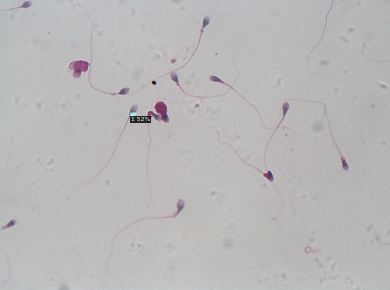

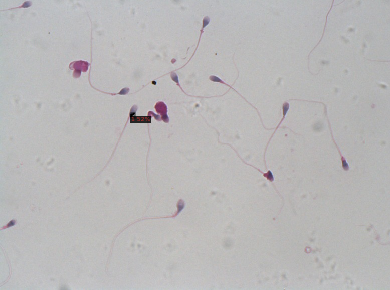

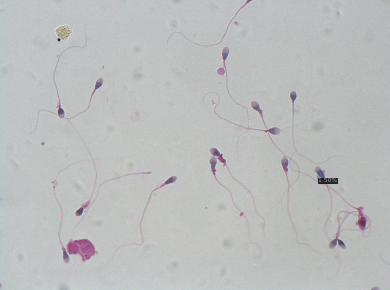

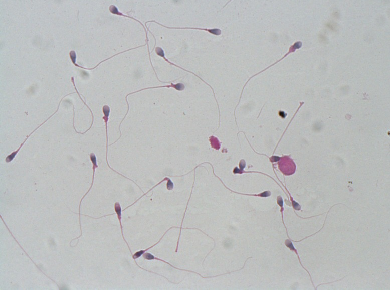

In [9]:
import json
import random

from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.utils.visualizer import Visualizer, ColorMode


dataset_dicts = json.load(open('coco_test.json'))['images']
dataset_metadata = MetadataCatalog.get("train")

for d in random.sample(dataset_dicts, 4):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=dataset_metadata, 
                   scale=0.5, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    
    showarray(out.get_image())